In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sympy import *
import numpy as np

In [3]:
data = pd.read_excel('https://fred.stlouisfed.org/graph/fredgraph.xls?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=IPUTIL&scale=left&cosd=1939-01-01&coed=2020-04-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2020-05-30&revision_date=2020-05-30&nd=1939-01-01', skiprows = 10 ) # скачиваем свежую версию данных

print(data) # смотрим на данные и видим, что дата в американском формате и данные отсортированы в правильном порядке по возрастанию даты

observation_date    IPUTIL
0         1939-01-01    3.3789
1         1939-02-01    3.4047
2         1939-03-01    3.4821
3         1939-04-01    3.5079
4         1939-05-01    3.5337
..               ...       ...
971       2019-12-01  103.4490
972       2020-01-01   98.6231
973       2020-02-01  102.1764
974       2020-03-01  100.2471
975       2020-04-01   99.3264

[976 rows x 2 columns]


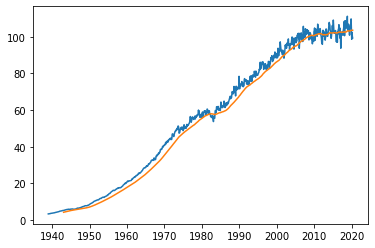

In [6]:
data.index = pd.to_datetime(data['observation_date']) # меняем идекс таблицы
valueColumn = data.columns[1] # сохраняем название колонки для удобства переиспользования
plt.plot(data.index, data[valueColumn]) # смотрим на график по оригинальным точкам
plt.plot(data.index, data[valueColumn].rolling(50).mean()) # и со скользящим средним

In [9]:
# Наблюдаем практически линейный рост непонятно чего, лезем на сайт и наконец читаем, что это за данные. Оказывается, это данные по промышленному производству всего, что связано с газом и электричеством, в относительных единицах, за 100% взято значение за 2012 год. С 40х по 80е года график растет очень ровно и быстро, практически без колебаний. Вспоминаем исторические события и делаем вывод, что после войны производство и потребление растет, но рано или поздно наступает очередной кризис и темпы замедливаются. В 80х годах случился нефтяной кризис, который привел к развалу СССР. Тут бы построить производную, чтобы оценить скорость роста, но в принципе и по графику скользящего среднего хорошо видно, когда скорость падала и возрастала. 

In [5]:
data[valueColumn].hist() # построим гистограмму и увидим видим достаточно очевидную картину, у нас много значений выше 100, производство со временем растет, вероятность вернуться в каменный век низкая.

NameError: name 'valueColumn' is not defined

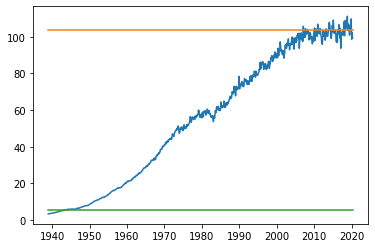

In [7]:
N = len(data.index)
quant_95 = [data[valueColumn].quantile(0.95)] * N
quant_5 = [data[valueColumn].quantile(0.05)] * N
plt.plot(data.index, data[valueColumn])
plt.plot(data.index, quant_95)
plt.plot(data.index, quant_5)

In [8]:
# Сверху видим в целом бесполезный график с квантилями и коридором. Производство может падать на каких-то локальных интервалах, но причин иметь какое-то ограничение сверху пока не наблюдается.

In [14]:
# Переходим к корреляции.
data.corr()
# И видим, что строить корреляцию по одному столбцу не имеет никакого смысла.

,IPUTIL
IPUTIL,1.0


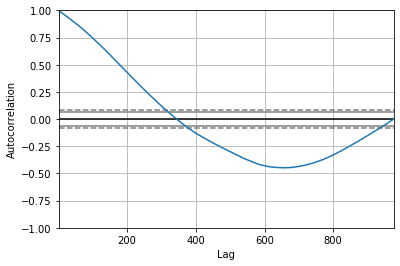

In [19]:
# Есть подозрение, что с авторреляцией тоже не выйдет. 
pd.plotting.autocorrelation_plot(data[valueColumn])

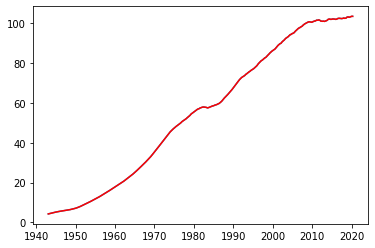

In [11]:
# Делаем вывод, график похож сам на себя при нулевом сдвиге. Это явно следует из природы вещей предметной области, ведь производство в среднем пока что всегда растет и не возвращается к прежним низким значениям. Т.е. сезонности не наблюдается. А наблюдаются какие-то локальные кризисы. Похоже, что если все таки построить график производный, чтобы увидеть изменение скорости роста, мы сможем более наглядно увидеть "сезонность" возникновения кризисов. На оригинальном графике видны два явных кризиса, когда скорость роста замедлилась.

df = data.copy()
df['time'] = pd.to_datetime(df.index).astype(int)/ 10**9
diff = np.diff(df[valueColumn]) / np.diff(df['time'])
plt.plot(df.index, df[valueColumn].rolling(50).mean())
plt.plot(data.index, data[valueColumn].rolling(50).mean(), color='red')

In [ ]:
# Построили график производной, он полностью совпал с оригинальным ;-) Видимо это связано с тем, что все значения уже и так даны относительно какого-то базового уровня и поэтому они уже показывают нам именно скорость. 

In [24]:
# Построим тренд
regressor = LinearRegression()
x_range = list(range(0, len(data)))
pd.DataFrame(x_range)

,0
0,0
1,1
2,2
3,3
4,4
...,...
971,971
972,972
973,973
974,974


In [26]:
regressor.fit(pd.DataFrame(x_range), data[valueColumn])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

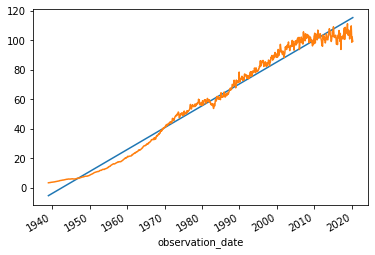

In [28]:
plt.plot(data.index, regressor.predict(pd.DataFrame(x_range)))
data[valueColumn].plot()

In [ ]:
# И снова видим тренд роста производства, что хорошо не только для США, но и для всего мира. 